# This basically a TSP (single-robot, no-failure, no-depletion)

Consider nodes placed uniformly along X and Y axes like so.

In [1]:
%pip install matplotlib scipy

Note: you may need to restart the kernel to use updated packages.


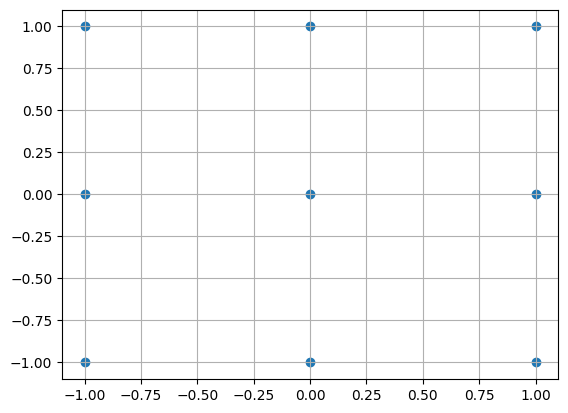

In [2]:
from matplotlib import pyplot as plt
from pprint import pp
import numpy as np

# This implementation only works with n = 2 and 3. It fails 4 and onwards
# Chose the number of nodes in an axis
n = 3
# Create a uniform (n, n, 2) numpy grid for MAXIMUM SPEED
grid = np.mgrid[-1:1:n*1j, -1.:1:n*1j]
grid = grid.reshape(grid.shape + (1,))
grid = np.concatenate((grid[0], grid[1]), axis=2)
# Sanity check
# pp(grid)
# pp(grid[:, :, 0].reshape(-1))
# pp(grid[:, :, 1].reshape(-1))

# Graphical sanity check
plt.figure()
plt.scatter(grid[:, :, 0], grid[:, :, 1])
plt.grid()
plt.show()

## TSP Model Formulation

### Sets and Indices
$i, j \in Nodes $: indices and set of nodes.

$\text{Edges}= \{(i,j) \in Nodes \times Nodes \}$: Set of allowed edges (All for now, so this is fully connected)

$S \subset Nodes$: A subset of the set of Nodes.

$G = (Nodes, Edges)$: A graph where the set $Nodes$ defines the set of nodes and the set $Edges$ defines the set of edges.

### Parameters

$d_{i, j} \in \mathbb{R}^+$: Distance from node $i$ to node $j$, for all $(i, j) \in Edges$.

### Decision Variables
$x_{i, j} \in \{0, 1\}$: This variable is equal to 1, if we decide to connect node $i$ with node $j$. Otherwise, the decision variable is equal to zero.

### Objective Function
- **Shortest Route**. Minimize the total distance of a route. A route is a sequence of nodes where the robot visits each node only once and returns to the starting node. This forms a loop and the robot can follow this persistently. 

\begin{equation}
\text{Min} \quad Z = \sum_{(i,j) \in \text{Edges}}d_{i,j} \cdot x_{i,j}
\tag{0}
\end{equation}

### Constraints
- **Symmetry Constraints**. For each edge $(i,j)$ that is visited, make sure $(j,i)$ is also marked visited/crossed.

\begin{equation}
x_{i, j} = x_{j, i} \quad \forall (i, j) \in Edges
\tag{1}
\end{equation}

- **Entering and leaving a node**. For each node $i$, ensure that this node is connected to two other nodes.

\begin{equation}
\sum_{(i,j) \in \text{Edges}}x_{i,j} = 2 \quad \forall  i \in Nodes
\tag{2}
\end{equation}

- **Subtour elimination**. These constraints ensure that for any subset of nodes $S$ of the set of $Nodes$, there is no cycle. That is, there is no route that visits all the nodes in the subset and returns to the origin node.

\begin{equation}
\sum_{(i \neq j) \in S}x_{i,j} \leq |S|-1 \quad \forall  S \subset  Nodes
\tag{3}
\end{equation}

- **Remark**. In general, if the number of nodes of the TSP is $n$, then the possible number of routes is n\!.
Since there are an exponential number of constraints ($2^{n} - 2$) to eliminate cycles, we use lazy constraints to dynamically eliminate those cycles.

In [3]:
import gurobipy as gp
from gurobipy import GRB
from itertools import combinations
import itertools

m = gp.Model()

# Calculate d_{ij} (d[i1, j1, i2, j2] is the cost from node (i1, j1) to (i2, j2))
coeffs = np.zeros((n,n,n,n))
for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
    coeffs[i1,j1,i2,j2] = np.sqrt((grid[i1,j1,0]-grid[i2,j2,0]) ** 2 + (grid[i1,j1,1]-grid[i2,j2,1]) ** 2)
    # print(f"({i1},{j1},{i2},{j2}):({grid[i1,j1,0]},{grid[i1,j1,1]},{grid[i2,j2,0]},{grid[i2,j2,1]}): {coeffs[i1,j1,i2,j2]}")

# Set the minimization problem
vars = m.addMVar((n,n,n,n), obj=coeffs, vtype=GRB.BINARY, name='x')

# Constraints: two edges incident to each city
cons = m.addConstrs(vars[i,j].sum() == 2 for i in range(n) for j in range(n))
# Constraints: no loopholes!
cons = m.addConstrs(vars[i,j,i,j] == 0 for i in range(n) for j in range(n))

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2419685
Academic license - for non-commercial use only - registered to luffs.ottoman04@icloud.com


In [4]:
# Callback - use lazy constraints to eliminate sub-tours

def subtourelim(model, where):
    # print(where == GRB.Callback.MIPSOL)
    if where == GRB.Callback.MIPSOL:
        # make a list of edges selected in the solution
        vals = model.cbGetSolution(model._vars)
        selected = np.transpose(np.where(vals > 0.5))
        # find the shortest cycle in the selected edge list
        tour = subtour(selected)
        # add subtour elimination constr. for every pair of cities in subtour
        if len(tour) == 1:
            try:
                model.cbLazy(gp.quicksum(model._vars[tour[0][0], tour[0][1], tour[0][0], tour[0][1]]) <= 0)
            except Exception as e:
                print(f"...: {tour}")
                print(e)
        elif len(tour) < n:
            model.cbLazy(gp.quicksum(model._vars[n1[0], n1[1], n2[0], n2[1]] for n1, n2 in combinations(tour, 2)) <= len(tour)-1)

# Given a list of edges, find the shortest subtour

def subtour(edges):
    unvisited = [(i, j) for i in range(n) for j in range(n)]
    cycle = range(n*n) # Dummy - guaranteed to be replaced
    while unvisited:  # true if list is non-empty
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = []
            for i1, j1, i2, j2 in edges:
                if (i1, j1) == current and (i2, j2) in unvisited:
                    neighbors.append((i2, j2))
                elif (i2, j2) == current and (i1, j1) in unvisited:
                    neighbors.append((i1, j1))
        if len(thiscycle) <= len(cycle):
            cycle = thiscycle # New shortest subtour
    return cycle

In [5]:
m._vars = vars
m.Params.lazyConstraints = 1
m.optimize(subtourelim)

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-3770K CPU @ 3.50GHz, instruction set [SSE2|AVX]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license - for non-commercial use only - registered to luffs.ottoman04@icloud.com
Optimize a model with 18 rows, 81 columns and 90 nonzeros
Model fingerprint: 0x0a84c74e
Variable types: 0 continuous, 81 integer (81 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
...: [(2, 2)]
Invalid axis specifications: 0
Found heuristic solution: objective 30.0153397
Presolve removed 9 rows and 9 columns
Presolve time: 0.00s
Presolved: 9 rows, 72 columns, 72 nonzeros
Variable types: 0 continuous, 72 integer (72 binary)
Found heuristic solution: objective 19.0000000

Root relaxation: objective 1.800000e+01, 9 iterations, 0

In [6]:
# Get the list "tour"
selected = np.transpose(np.where(m._vars.x > 0.5))
tour = subtour(selected)
print(tour)
assert len(tour) == n ** 2 

[(0, 0), (0, 1), (0, 2), (1, 2), (1, 1), (1, 0), (2, 0), (2, 1), (2, 2)]


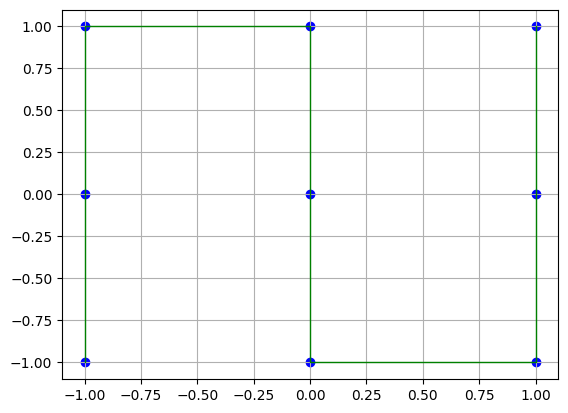

In [7]:
# Graphical sanity check for the tour
plt.figure()
plt.scatter(grid[:, :, 0], grid[:, :, 1], color="blue")

tour_np = np.array([]).reshape(0, 2)
for i, j in tour:
    tour_np = np.concatenate((tour_np, grid[i, j].reshape(1, 2)))
plt.plot(tour_np[:, 0], tour_np[:, 1], color="green", linewidth=1)
plt.grid()
plt.show()
